# Google Colab으로 오픈소스 LLM 구동하기

## 1단계 - LLM 양자화에 필요한 패키지 설치
- bitsandbytes: Bitsandbytes는 CUDA 사용자 정의 함수, 특히 8비트 최적화 프로그램, 행렬 곱셈(LLM.int8()) 및 양자화 함수에 대한 경량 래퍼
- PEFT(Parameter-Efficient Fine-Tuning): 모델의 모든 매개변수를 미세 조정하지 않고도 사전 훈련된 PLM(언어 모델)을 다양한 다운스트림 애플리케이션에 효율적으로 적용 가능
- accelerate: PyTorch 모델을 더 쉽게 여러 컴퓨터나 GPU에서 사용할 수 있게 해주는 도구


In [2]:
#양자화에 필요한 패키지 설치
%%capture
!pip install -U bitsandbytes
!pip install -U git+https://github.com/huggingface/transformers.git
!pip install -U git+https://github.com/huggingface/peft.git
!pip install -U git+https://github.com/huggingface/accelerate.git

## 2단계 - 트랜스포머에서 BitsandBytesConfig를 통해 양자화 매개변수 정의하기


* load_in_4bit=True: 모델을 4비트 정밀도로 변환하고 로드하도록 지정
* bnb_4bit_use_double_quant=True: 메모리 효율을 높이기 위해 중첩 양자화를 사용하여 추론 및 학습
* bnd_4bit_quant_type="nf4": 4비트 통합에는 2가지 양자화 유형인 FP4와 NF4가 제공됨. NF4 dtype은 Normal Float 4를 나타내며 QLoRA 백서에 소개되어 있습니다. 기본적으로 FP4 양자화 사용
* bnb_4bit_compute_dype=torch.bfloat16: 계산 중 사용할 dtype을 변경하는 데 사용되는 계산 dtype. 기본적으로 계산 dtype은 float32로 설정되어 있지만 계산 속도를 높이기 위해 bf16으로 설정 가능



In [1]:
import torch
import warnings
warnings.filterwarnings('ignore')
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

## 3단계 - 경량화 모델 로드하기

이제 모델 ID를 지정한 다음 이전에 정의한 양자화 구성으로 로드합니다.

In [4]:
%%capture
! pip install accelerate

In [2]:
model_id = "kyujinpy/Ko-PlatYi-6B"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config, device_map="auto")

Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  1.89s/it]


In [3]:
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(78464, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=512, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=512, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm(

## 4단계 - 잘 실행되는지 확인

In [5]:
# Define the chat template directly in the code
chat_template = "<|startoftext|>{role}: {content}<|endoftext|>"

# Messages to be encoded
messages = [
    {"role": "user", "content": "딥러닝 대해 알려줘"}
]

# Apply the chat template
encodeds = tokenizer.apply_chat_template(messages, chat_template=chat_template, return_tensors="pt")

# Move the encoded inputs to the specified device
model_inputs = encodeds.to(device)

# Generate the response using the model
generated_ids = model.generate(model_inputs, max_new_tokens=1000, do_sample=True)

# Decode the generated IDs to text
decoded = tokenizer.batch_decode(generated_ids)

# Print the first decoded response
print(decoded[0])


Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


<|startoftext|> {role}: {content}<|endoftext|>The following is an article excerpt from. "Giving in Languages Other than the Primary Language" by Mary R. Spannaus published in Language, Speech, and Hearing Services of Children. In this article there is a brief explanation of the language that we as Speech Language Pathologists use in sessions with children. When to use it and the benefits of using it. You will find it here.
For more information, please check out her website which you can find here.
GIVING IN LANGUAGES OTHER THAN THE PRIMARY LANGUAGE
As with any therapy session, you have a number of goals you hope to achieve with your client. This goal includes using the client’s native language (the language the client speaks daily with their parents or in the community, such as Spanish) to describe concepts that are important to them, while helping them to understand the concepts presented in the primary language (English in this case), and communicating with them in the spoken languag

## 5단계- RAG 시스템 결합하기

In [6]:
# pip install시 utf-8, ansi 관련 오류날 경우 필요한 코드
import locale
# import warnings
# warnings.filterwarnings('ignore')

def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [13]:
!pip -q install langchain pypdf chromadb sentence-transformers faiss-gpu
!pip install langchain_community

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 5.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 990.6/990.6 kB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.8/295.8 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.3/584.3 kB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 92.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.8/273.8 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.1 MB/s 

In [15]:
!pip install langchain_huggingface

In [7]:
# from langchain.llms import HuggingFacePipeline
from langchain_huggingface import HuggingFacePipeline
from langchain.prompts import PromptTemplate
from langchain.embeddings.huggingface import HuggingFaceEmbeddings
from transformers import pipeline
from langchain.chains import LLMChain

text_generation_pipeline = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    temperature=0.2,
    return_full_text=True,
    max_new_tokens=300,
)

prompt_template = """
### [INST]
Instruction: Answer the question based on your knowledge.
Here is context to help:
{context}
### QUESTION:
{question}
[/INST]
 """

koplatyi_llm = HuggingFacePipeline(pipeline=text_generation_pipeline)

# Create prompt from prompt template
prompt = PromptTemplate(
    input_variables=["context", "question"],
    template=prompt_template,
)

# Create llm chain
llm_chain = LLMChain(llm=koplatyi_llm, prompt=prompt)

/home/ancestor9/.venv/lib/python3.12/site-packages/langchain_core/_api/deprecation.py:141: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use RunnableSequence, e.g., `prompt | llm` instead.
  warn_deprecated(


In [8]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain.document_loaders import PyPDFLoader
from langchain.schema.runnable import RunnablePassthrough

### 한 파일로 처리하는 방법

## **핵심정리**

- pdf로 만든다는 것 알겠는데 아래처럼 생긴 데이터를 document object를 어떻게 만드는지 알려줘?
- 엑셀(test)의 정보제공컬럼까지 copy하여 chatGPT에게 물어보고
- Document는 page_content, metadata의 속성을 갖고 그런데 metadata에는 국가명, 수집일자, 제목, 내용, 정보제공국가로 구성된다. 내용이 바로 page_content이다.

- pdf로 만든다는 것 알겠는데 아래처럼 생긴 데이터를 document object를 어떻게 만드는지 알려줘?
- 엑셀(test)의 정보제공컬럼까지 copy하여 chatGPT에게 물어보고
- Document는 page_content, metadata의 속성을 갖고 그런데 metadata에는 국가명, 수집일자, 제목, 내용, 정보제공국가로 구성된다. 내용이 바로 page_content이다.

### **기사를 보고 원인요소를 예측**
#### 1. Data Preparation
- documents list contains both the page_content and the 식품등 유형 in its metadata.
- label each document with the correct "식품등 유형".
##### 1.1. 훈련데이터 준비(2020년 ~ 2022년)
- 전체 엑셀파일 읽어서 피클 gzip을 압축하여 'Combined_Food_Safety_Data_2015_2023_gzip.pkl'로 저장

In [11]:
import pandas as pd
import glob
# Use glob to get all file paths matching the pattern for the years 2020 to 2022
file_paths = glob.glob('/home/ancestor9/python/*.xls')
print(file_paths)

# Initialize an empty list to store dataframes
dfs = []
ttl = 0
# Read each Excel file and append to the list
for file_path in file_paths:
    df = pd.read_excel(file_path)
    df['수집일자'] = pd.to_datetime(df['수집일자'])
    ttl += df.shape[0]
    print(file_path)
    file_name = file_path.split('.')[0]
    print(f'{file_name}: 데이터크기 {df.shape}, 누적크기는 {ttl}')
    dfs.append(df)
# Concatenate all dataframes into one
combined_df = pd.concat(dfs, ignore_index=True)
combined_df

pd.to_datetime(df['수집일자'])

# # Save the combined dataframe to a new Excel file
output_file_path = 'Combined_Food_Safety_Data_2015_2023_gzip.pkl'
combined_df.to_pickle(output_file_path, compression='gzip')

print(f"Combined file saved to {output_file_path}")


['/home/ancestor9/python/식품안전정보DB(2021).xls', '/home/ancestor9/python/식품안전정보DB(2022).xls', '/home/ancestor9/python/식품안전정보DB(2023).xls']
/home/ancestor9/python/식품안전정보DB(2021).xls
/home/ancestor9/python/식품안전정보DB(2021): 데이터크기 (23135, 8), 누적크기는 23135
/home/ancestor9/python/식품안전정보DB(2022).xls
/home/ancestor9/python/식품안전정보DB(2022): 데이터크기 (22233, 8), 누적크기는 45368
/home/ancestor9/python/식품안전정보DB(2023).xls
/home/ancestor9/python/식품안전정보DB(2023): 데이터크기 (20775, 8), 누적크기는 66143
Combined file saved to Combined_Food_Safety_Data_2015_2023_gzip.pkl


In [13]:
import pandas as pd
# Assuming your DataFrame `df` has a column '식품등유형'
file_path = 'Combined_Food_Safety_Data_2015_2023_gzip.pkl'  # Replace with your actual file path
df_all = pd.read_pickle(file_path, compression='gzip')  # Update with the correct file path
df_all.head(2)

,국가명,수집일자,제목,내용,정보제공국가,정보구분,식품등유형,원인요소
0,중국,2021-12-31,"중국 장시성 시장감독관리국, 부적합 식품 상황 통보(2021년 제51기)_육류제품","[중앙 계획 샘플검사]장시(江西)성 시장감독관리국, 12대 식품(423건 샘플) 중...",중국,위해식품정보,가공식품>식육가공품 및 포장육>양념육류,화학적 위해요소>식품첨가물>삭카린나트륨
1,중국,2021-12-31,"중국 장시성 시장감독관리국, 부적합 식품 상황 통보(2021년 제52기)","장시(江西)성 시장감독관리국, 12대 식품(107건 샘플) 중 3건 부적합 <부적합...",중국,위해식품정보,가공식품>가공식품 일반>가공식품 일반,안전위생>위생>위생


In [14]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66143 entries, 0 to 66142
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   국가명     66143 non-null  object        
 1   수집일자    66143 non-null  datetime64[ns]
 2   제목      66143 non-null  object        
 3   내용      66143 non-null  object        
 4   정보제공국가  66143 non-null  object        
 5   정보구분    66143 non-null  object        
 6   식품등유형   66143 non-null  object        
 7   원인요소    66143 non-null  object        
dtypes: datetime64[ns](1), object(7)
memory usage: 4.0+ MB


In [26]:
# prompt: 컬럼의 값이 object를 string으로 변환

# 컬럼의 값이 object를 string으로 변환
for col in df_all.columns:
    if df_all[col].dtype == 'object':
        df_all[col] = df_all[col].astype(str)

df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20775 entries, 0 to 20774
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   국가명     20775 non-null  object        
 1   수집일자    20775 non-null  datetime64[ns]
 2   제목      20775 non-null  object        
 3   내용      20775 non-null  object        
 4   정보제공국가  20775 non-null  object        
 5   정보구분    20775 non-null  object        
 6   식품등유형   20775 non-null  object        
 7   원인요소    20775 non-null  object        
dtypes: datetime64[ns](1), object(7)
memory usage: 1.3+ MB


#### 훈련데이터는 2015년부터 2023년 6월31일까지

In [17]:
df.columns

Index(['국가명', '수집일자', '제목', '내용', '정보제공국가', '정보구분', '식품등유형', '원인요소'], dtype='object')

In [18]:
# Define a custom Document class
class Document:
    def __init__(self, page_content, metadata):
        self.page_content = page_content
        self.metadata = metadata

    def __repr__(self):
        content_preview = str(self.page_content) if pd.notna(self.page_content) else 'No Content'
        return f"Document(page_content={content_preview}..., metadata={self.metadata})"

# Create documents from the DataFrame
documents = [
    Document(
        page_content=row['내용'],
        metadata={
            '국가명': row['국가명'],
            '수집일자': row['수집일자'],
            '제목': row['제목'],
            '원인요소': row['원인요소']  # Ensure this column exists in your data
        }
    )
    for _, row in df.iterrows()
]

# Prepare data for training
data = [(doc.page_content, doc.metadata['원인요소']) for doc in documents if '원인요소' in doc.metadata]
df_data = pd.DataFrame(data, columns=['page_content', '원인요소'])

# Convert labels to integers
label_mapping = {label: idx for idx, label in enumerate(df_data['원인요소'].unique())}
df_data['label'] = df_data['원인요소'].map(label_mapping)
df_data

,page_content,원인요소,label
0,- 일자 : 2023.12.30- 지역: 잉글랜드- 제품명 : Chiltern Ar...,생물학적 위해요소>미생물>대장균,0
1,"싱가포르 식품청(SFA)은 Mr Edmund Lim Wee Kiat의 ""테이크아웃용...",안전위생>안전>안전,1
2,싱가포르 법원은 온라인 식료품점인 FishMeatz LLP에 미허가 냉장 창고를 불...,안전위생>안전>안전,1
3,- 일자: 2023.12.29.- 제품명: Rude Health Organic Co...,표시광고>알레르기>우유,2
4,- 발생 기간: 2023년 7월부터 현재까지- 발생 지역: 영국 스코틀랜드- 발생 ...,생물학적 위해요소>미생물>병원성 대장균,3
...,...,...,...
20770,-일자 : 2022.12.30.-지역 : 프랑스 전역-제품명 : tartare de...,생물학적 위해요소>미생물>리스테리아 모노사이토제네스,26
20771,"[감염현황, 12월 30일 기준] - 발생사례: 15건- 입원자 : 2명- 사망자 ...",생물학적 위해요소>미생물>살모넬라(Salmonella spp.),11
20772,-일시: 2022년 12월 29일-제품명: ① Cheese-kama(チーズ蒲) 12...,생물학적 위해요소>미생물>곰팡이수,23
20773,"- 일자: 2022.12.30- 유통지역: 독일 Berlin, Hamburg, Sc...",물리적 위해요소>이물질>유리,208


In [76]:
df_data.label.nunique()

956

<Axes: xlabel='label'>

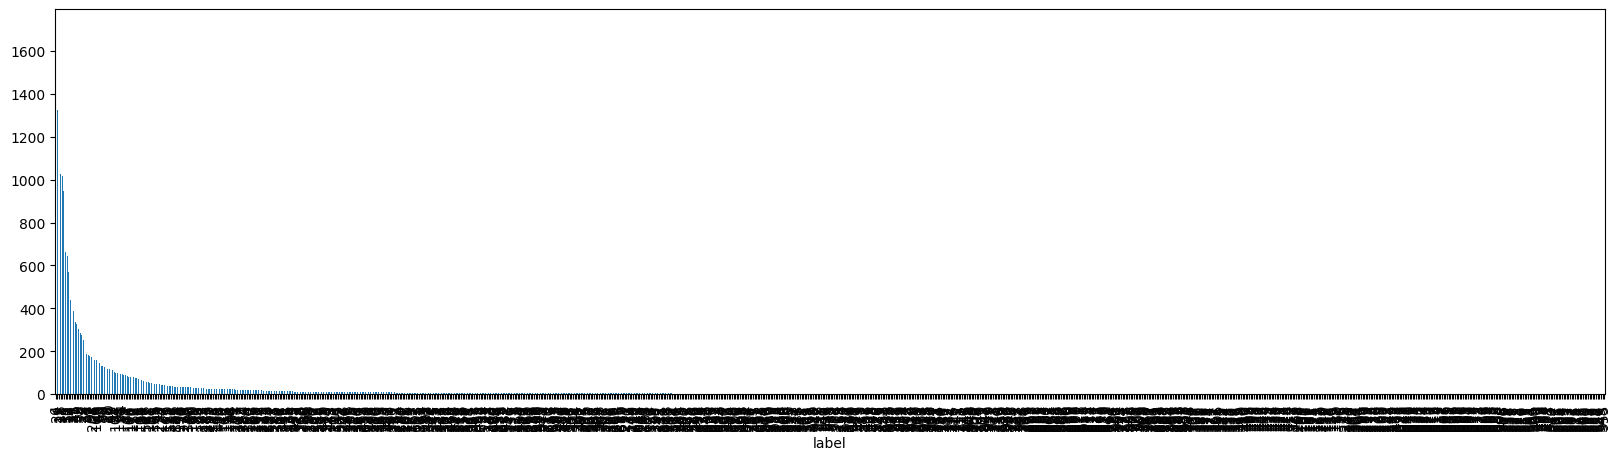

In [78]:
import matplotlib.pyplot as plt

df_data.label.value_counts().plot(kind='bar', figsize=(20, 5))


In [19]:
documents[0]

Document(page_content=- 일자 : 2023.12.30- 지역: 잉글랜드- 제품명 : Chiltern Artisan Chilli Sticks (모든 팩 사이즈, 소비기한(Use by)이 표시된 경우 모든 소비기한)- 회수사 : Chiltern Artisan- 회수사유 : 일부 제품의 대장균(E.coli) 오염 발견- 제품사진 : https://s3-eu-west-1.amazonaws.com/fsa-alerts-files/production/FSA-PRIN-52-2023/Customer-notice-Chiltern-Artisan-recalls-Chilli-sticks.pdf..., metadata={'국가명': '영국', '수집일자': Timestamp('2023-12-31 00:00:00'), '제목': '[회수]영국 Chiltern Artisan, 대장균 오염으로 고추 스틱 회수', '원인요소': '생물학적 위해요소>미생물>대장균'})

In [20]:
isinstance(documents[0].page_content, str)

True

In [22]:
# from langchain.embeddings import HuggingFaceEmbeddings
from langchain_huggingface import HuggingFaceEmbeddings

model_name = "jhgan/ko-sbert-nli"
encode_kwargs = {'normalize_embeddings': True}
hf = HuggingFaceEmbeddings(
    model_name=model_name,
    encode_kwargs=encode_kwargs
)

def ensure_string(text):
    if not isinstance(text, str):
        return str(text)
    return text

documents = [doc for doc in documents if isinstance(doc.page_content, str)]

db = FAISS.from_documents(documents, hf)
retriever = db.as_retriever(
                            search_type="similarity",
                            search_kwargs={'k': 3}
                        )

In [23]:
rag_chain = (
 {"context": retriever, "question": RunnablePassthrough()}
    | llm_chain
)

In [24]:
result = rag_chain.invoke("식중독 관련 기사가 몇건이 있었지")

In [25]:
result

{'context': [Document(metadata={'국가명': '미국', '수집일자': Timestamp('2023-09-07 00:00:00'), '제목': "포르투갈 보건국, 지난 7월 이후 'broa de milho' 섭취 관련 식중독 원인은 트로판알칼로이드 과량으로 밝혀져", '원인요소': '생물학적 위해요소>생물독소>기타(트로판알칼로이드)'}, page_content="* 관련 기수집 정보: [식중독]포르투갈 보건국, 특정 지역 내 옥수수빵의 일종인 'broa de milho' 섭취 관련 식중독 의심 사례 187건 발생 (수집일자: 2023-08-15) 미국 언론 Food Safety News에 따르면, 포르투갈 보건국은 지난 7월 이후 국내 일부 지역에서 옥수수빵의 일종인 'broa de milho' 섭취와 관련하여 209건의 사례(40명 이상 병원 치료)가 보고된 식중독에 대해 조사한 결과, 식중독 원인은 과량의 트로판알칼로이드(아트로핀 및 스코폴라민)였다고 밝혔음. "),
  Document(metadata={'국가명': '미국', '수집일자': Timestamp('2023-10-26 00:00:00'), '제목': '[식중독]핀란드, 62명 살모넬라 식중독 발생... 발병원으로 새싹 채소 지목', '원인요소': '생물학적 위해요소>미생물>살모넬라(Salmonella spp.)'}, page_content='-일시: 2023. 10. 25.-지역: 핀란드 전역-발생 규모 : 핀란드 국립보건복지연구소(THL)은 지난 8월과 10월 전국 각지에서 62명이 살모넬라 엔테리티디스로 인해 식중독에 걸렸다고 보고함.  -발생 사유 : 당국 인터뷰 24명 중 23명이 증상 호소 이전 새싹 채소(sprouts)를 섭취한 적이 있다고 답함. 환자들은 증상 호소 7일 내로 두 가지 다른 새싹 채소 제품을 섭취하였음. 두 제품 모두 이름이 알려지지 않은 동일한 생산업체가 제조함. -기타 : 해당 업체의 새싹 채소 제품에서 채취한 다른 샘플에서는 살모넬라균이 

In [26]:
result.keys()

dict_keys(['context', 'question', 'text'])

In [27]:
result = rag_chain.invoke("수집일자가 2023년 3월인 데이터 중에서 '내용'이 식품 위해에 중대한 영향을 미치는  되는 기사 3건을 요약해줘")

for i in result['context']:
    print(f"주어진 근거: {i.metadata['수집일자']} {i.page_content} / 출처: {i.metadata['제목']} - {i.metadata['원인요소']} \n\n")

print(f"\n답변: {result['text']}")

주어진 근거: 2023-03-06 00:00:00 일본 후생노동성은 2023년 3월 수입 시 식품 등의 식품위생법 위반사례를 공개함.-제품명: 신선 참깨(生鮮ゴマの種子)-수출자: ASIAN COMMODITIES CORPORATION.-생산국: 파키스탄-부적합 내용: 아플라톡신(Aflatoxin) 12 μg/kg(B1: 11.6 μg/kg) 검출-조치 내용: 폐기, 반송 등을 지시(전량 보관)-공표일: 2023년 3월 3일-비고: 검사명령 / 출처: 일본 후생노동성, 수입식품등 식품위생법 위반사례(1) - 파키스탄산 신선 참깨(1) - 생물학적 위해요소>곰팡이독소>아플라톡신(B1, B2, G1 및 G2) 


주어진 근거: 2023-04-03 00:00:00 일본 후생노동성은 2023년 3월 수입 시 식품 등의 식품위생법 위반사례를 공개함.-제품명: 기타 옥수수(GM 불분별)(その他のとうもろこし(GM不分別))-수출자: EVERCORN,INC.-생산국: 미국-부적합 내용: 아플라톡신(Aflatoxin) 12 μg/kg(B1: 12.0 μg/kg) 검출-조치 내용: 폐기, 반송 등을 지시(전량 보관)-공표일: 2023년 3월 31일-비고: 검사명령 / 출처: 일본 후생노동성, 수입식품등 식품위생법 위반사례(4) - 미국산 기타 옥수수(GM 불분별)(2) - 생물학적 위해요소>곰팡이독소>아플라톡신(B1, B2, G1 및 G2) 


주어진 근거: 2023-03-16 00:00:00 일본 후생노동성은 2023년 3월 수입 시 식품 등의 식품위생법 위반사례를 공개함.-제품명: 신선 참깨(生鮮ゴマの種子)-수출자: AKSHAJ COMMODITIES LIMITED-생산국: 탄자니아-부적합 내용: 성분규격 부적합 - 이미다클로프리드(Imidacloprid) 0.21 ppm 검출-조치 내용: 폐기, 반송 등을 지시(전량 보관)-공표일: 2023년 3월 15일-비고: 검사명령 / 출처: 일본 후생노동성, 수입식품등 식품위생법 위반사례(12) - 탄자니아산 신선 참깨 - 화학적 위해

In [28]:
result['text']

"\n### [INST]\nInstruction: Answer the question based on your knowledge.\nHere is context to help:\n[Document(metadata={'국가명': '일본', '수집일자': Timestamp('2023-03-06 00:00:00'), '제목': '일본 후생노동성, 수입식품등 식품위생법 위반사례(1) - 파키스탄산 신선 참깨(1)', '원인요소': '생물학적 위해요소>곰팡이독소>아플라톡신(B1, B2, G1 및 G2)'}, page_content='일본 후생노동성은 2023년 3월 수입 시 식품 등의 식품위생법 위반사례를 공개함.-제품명: 신선 참깨(生鮮ゴマの種子)-수출자: ASIAN COMMODITIES CORPORATION.-생산국: 파키스탄-부적합 내용: 아플라톡신(Aflatoxin) 12 μg/kg(B1: 11.6 μg/kg) 검출-조치 내용: 폐기, 반송 등을 지시(전량 보관)-공표일: 2023년 3월 3일-비고: 검사명령'), Document(metadata={'국가명': '일본', '수집일자': Timestamp('2023-04-03 00:00:00'), '제목': '일본 후생노동성, 수입식품등 식품위생법 위반사례(4) - 미국산 기타 옥수수(GM 불분별)(2)', '원인요소': '생물학적 위해요소>곰팡이독소>아플라톡신(B1, B2, G1 및 G2)'}, page_content='일본 후생노동성은 2023년 3월 수입 시 식품 등의 식품위생법 위반사례를 공개함.-제품명: 기타 옥수수(GM 불분별)(その他のとうもろこし(GM不分別))-수출자: EVERCORN,INC.-생산국: 미국-부적합 내용: 아플라톡신(Aflatoxin) 12 μg/kg(B1: 12.0 μg/kg) 검출-조치 내용: 폐기, 반송 등을 지시(전량 보관)-공표일: 2023년 3월 31일-비고: 검사명령'), Document(metadata={'국가명': '일본', '수집일자': Timestamp('2023-0

In [29]:
result = rag_chain.invoke("특정 식품등유형에 해당하는 위해기사를 보여줘. (예: 가공식품)")

for i in result['context']:
    print(f"주어진 근거: {i.metadata['수집일자']} {i.page_content} / 출처: {i.metadata['제목']} - {i.metadata['원인요소']} \n\n")

print(f"\n답변: {result['text']}")

주어진 근거: 2023-06-23 00:00:00 위생복지부는 알레르기 체질인 소비자가 안심하고 섭취할 수 있도록 포장식품업체에 식품 알레르기 표시 정보 공개를 강화하도록 이미 요구했음. 포장식품에 갑각류, 망고, 땅콩, 우유 및 양유, 알, 견과류, 참깨, 글루텐 함유 곡물, 대두, 어류 등 10종 및 그 제품이 함유되어 있는 경우, 그리고 아황산염류 등을 사용하여 최종 제품의 이산화황 잔류량이 10mg/kg 이상인 경우, 제품의 용기 또는 외포장에 해당 알레르기 유발 내용물 명칭 등의 주의 정보를 반드시 표시해야 함. 그밖에 위생복지부는 두족류(예:오징어), 권패류(예:우렁이), 종자류(예:해바라기씨), 키위 등 4종 및 그 제품에 대해 주의 문구를 표시하도록 업체에 권고하였음. 식품 생산 제조 과정에서 사용하지 않았으나, 공용 공장, 설비 또는 생산라인에서 알레르기 유발 내용물을 처리한 경우, '본 제품의 생산 제조 공장의 설비 또는 생산라인에서 OO를 처리하고 있습니다.' 또는 동일한 의미의 문구를 표시하도록 권고함. 식품약물관리서는 알레르기 체질인 소비자에 포장 상에 표시된 '본 제품에는 OO이 함유되어 있습니다', '본 제품에는 OO이 함유되어 있어 알레르기 체질인 경우 섭취에 적합하지 않습니다' 또는 동일한 의미의 문구를 꼭 확인할 것을 당부하는 바임. / 출처: 대만 식약서, 포장식품 알레르기 표시 확인 당부 - 표시광고>알레르기>알레르기일반 


주어진 근거: 2023-11-28 00:00:00 -검사 방법: 식품약물관리서 공개 권고 검사방법 "식품 중 에틸렌옥사이드 및 그 반응산물 2-클로로에탄올의 검사방법"(TFDAP0022.04)【2023.07.05 발효】-부적합 사유: 에틸렌옥사이드 15.4 mg/kg-법정 제한 표준: 해당 제품은 식품안전위생관리법 제15조 관련 "농약잔류 허용량 표준" 규정에 부적합-수출국: 미국-제품명: 뉴올리언스 매운맛 소스팩(紐奧良辣味調味包)(259704 TGIF BLACKENING SPICE GMO FREE 2

In [30]:
result.keys()

dict_keys(['context', 'question', 'text'])

In [31]:
result['context']

[Document(metadata={'국가명': '대만', '수집일자': Timestamp('2023-06-23 00:00:00'), '제목': '대만 식약서, 포장식품 알레르기 표시 확인 당부', '원인요소': '표시광고>알레르기>알레르기일반'}, page_content="위생복지부는 알레르기 체질인 소비자가 안심하고 섭취할 수 있도록 포장식품업체에 식품 알레르기 표시 정보 공개를 강화하도록 이미 요구했음. 포장식품에 갑각류, 망고, 땅콩, 우유 및 양유, 알, 견과류, 참깨, 글루텐 함유 곡물, 대두, 어류 등 10종 및 그 제품이 함유되어 있는 경우, 그리고 아황산염류 등을 사용하여 최종 제품의 이산화황 잔류량이 10mg/kg 이상인 경우, 제품의 용기 또는 외포장에 해당 알레르기 유발 내용물 명칭 등의 주의 정보를 반드시 표시해야 함. 그밖에 위생복지부는 두족류(예:오징어), 권패류(예:우렁이), 종자류(예:해바라기씨), 키위 등 4종 및 그 제품에 대해 주의 문구를 표시하도록 업체에 권고하였음. 식품 생산 제조 과정에서 사용하지 않았으나, 공용 공장, 설비 또는 생산라인에서 알레르기 유발 내용물을 처리한 경우, '본 제품의 생산 제조 공장의 설비 또는 생산라인에서 OO를 처리하고 있습니다.' 또는 동일한 의미의 문구를 표시하도록 권고함. 식품약물관리서는 알레르기 체질인 소비자에 포장 상에 표시된 '본 제품에는 OO이 함유되어 있습니다', '본 제품에는 OO이 함유되어 있어 알레르기 체질인 경우 섭취에 적합하지 않습니다' 또는 동일한 의미의 문구를 꼭 확인할 것을 당부하는 바임."),
 Document(metadata={'국가명': '대만', '수집일자': Timestamp('2023-11-28 00:00:00'), '제목': "대만, 미국에서 수출한 '소스류' 잔류농약 규정 부적합", '원인요소': '화학적 위해요소>잔류농약>기타(에틸렌옥사이드(Ethylene Oxide))'}, page_content='-검사 방법: 식품약물관리서 공개 권고 검사방법

In [32]:
df_all[(df_all['수집일자'] == '2023-04-03') & (df_all['국가명'] == '일본') & (df_all['원인요소'] == '표시광고>알레르기>알레르기일반')]

,국가명,수집일자,제목,내용,정보제공국가,정보구분,식품등유형,원인요소
61338,일본,2023-04-03,"일본 소비자청, '가공식품의 식품 알레르기 표시 핸드북' 개정","*관련 기수집 정보: 일본 소비자청, 가공식품의 식품알레르기 표시 핸드북 공개 (수...",일본,글로벌 동향정보,식품일반>식품일반>식품일반,표시광고>알레르기>알레르기일반


In [33]:
result = rag_chain.invoke("식중독은 언제 많이 발생하는가")
for i in result['context']:
    print(f"주어진 근거: {i.page_content} / 출처: {i.metadata['제목']} - {i.metadata['원인요소']} \n\n")

print(f"\n답변: {result['text']}")

주어진 근거: 미국 언론 Food Safety News에 따르면, 스웨덴 공중보건청(Folkhälsomyndigheten)은 지난 6월 말과 7월 초  캠필로박터균 식중독 환자가 증가했으며, 신선 닭고기가 오염원으로 유력하다고 발표하였음. 당국은 주당 식중독 환자 수가 6월에는 70명이었지만, 2주 전은 100명, 지난주는 140여명으로 증가했으며, 식중독 증가 추세가 예년보다 갑자기, 그리고 다소 일찍 시작된 것 같다고 설명함.  / 출처: 스웨덴 공중보건청, 최근 캠필로박터균 환자 증가해...오염원으로 신선 닭고기 유력 - 생물학적 위해요소>미생물>캠필로박터 제주니 


주어진 근거: 최근 발표된 데이터에 따르면, 뉴질랜드에서 2022년에 대부분의 식중독 감염이 증가했다고 보고함. 이 보고서(*)는 일차산업부(MPI)의 식품안전부(NZFS)에서 공개하였음. 2022년 27개(253건의 사례) 발생의 대부분은 식품 사업자와 관련이 있었고, 소비자 가정에서 준비한 식품과 관련된 발생은 5건에 불과하였음.  캠필로박터, 살모넬라, 시가독소 생산 대장균(STEC), 리스테리아 감염은 2021년 때보다 2022년 증가하였음.  * 뉴질랜드 일차산업부 '2022년 뉴질랜드 식중독 관련 연간 보고"https://www.mpi.govt.nz/dmsdocument/58789-Annual-report-concerning-Foodborne-Diseases-in-New-Zealand-2022  / 출처: 뉴질랜드 일차산업부, 데이터에 따르면 식중독 감염이 증가해 - 생물학적 위해요소>미생물>미생물일반 


주어진 근거: * 관련 기수집 정보: [식중독]핀란드, 급식으로 제공된 토르티야 섭취 후 200여 명 식중독 (수집일자: 2023-08-19) -일시: 2023. 8. 22.-지역: 핀란드 미켈리(Mikkeli)시-발생 규모 : 600명 이상 (증상 비교적 경미. 입원환자 없음)-발생 사유 : 초기 조사 결과, 야채 토르티야를 제공한 모든 학교에서 복통, 메스꺼움, 두통 등을

### 2. Model Training
- We'll use a simple text classification model. For this example, we'll use transformers from Hugging Face.

In [34]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
import torch

# Define the dataset class
class FoodTypeDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = self.texts[item]
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Load the tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=len(label_mapping))

# Split the data
train_texts, val_texts, train_labels, val_labels = train_test_split(df_data['page_content'].tolist(), df_data['label'].tolist(), test_size=0.1, random_state=42)

# Create the datasets
train_dataset = FoodTypeDataset(train_texts, train_labels, tokenizer, max_len=128)
val_dataset = FoodTypeDataset(val_texts, val_labels, tokenizer, max_len=128)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size for training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

# Create the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

# Train the model
trainer.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,6.868400
20,6.874600
30,6.840200
40,6.835700
50,6.792700
60,6.741100
70,6.666700
80,6.554700
90,6.376500
100,6.196400


TrainOutput(global_step=1755, training_loss=3.209627563389618, metrics={'train_runtime': 510.8486, 'train_samples_per_second': 109.8, 'train_steps_per_second': 3.435, 'total_flos': 3721143610211328.0, 'train_loss': 3.209627563389618, 'epoch': 3.0})

### 3. Prediction
- To make predictions with the trained model, we need to encode the new text data and use the model to predict the label.

In [35]:
import torch

# Function to predict the "원인요소" for new articles
def predict_food_type(page_content):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    inputs = tokenizer.encode_plus(
        page_content,
        add_special_tokens=True,
        max_length=128,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    logits = outputs.logits
    prediction = torch.argmax(logits, dim=1).item()

    # Map the integer prediction back to the label
    label_map = {v: k for k, v in label_mapping.items()}
    predicted_label = label_map[prediction]

    return predicted_label

# Example usage
new_article = '''
호주 언론 'News.com.au'에 따르면, 서호주(West Australia)주 보건당국이 Qukes 브랜드의 오이(baby cucumber) 제품을 섭취한
사람들에게서 설사 증세가 발생하자 해당 제품을 긴급 회수 조치한다고 발표했음. 크리스마스 기간 동안 12명 이상이 해당 오이를 섭취한 후 아팠음.
12월 23일 퍼스(Perth)의 한 슈퍼마켓에서 구입한 오이에서 살모넬라 티피무리움(Salmonella Typhimurium)이 검출되었음.
주 보건당국은 관련 조사에 착수했으며, 2022년 12월에 구입한 제품을 섭취하지 않도록 당부했음.
언론은 다른 브랜드의 오이는 현재까지 영향을 받지 않았다고 보도했음.
'''
predicted_type = predict_food_type(new_article)
print(f"The predicted 원인요소 is: {predicted_type}")

The predicted 원인요소 is: 생물학적 위해요소>미생물>살모넬라(Salmonella spp.)


### 2020년도 데이터의 원인요소를 예측하기
- 분류유형을 자동으로 구분하여 label이 가능

In [40]:
tf = pd.read_excel('/home/ancestor9/python/식품안전정보DB(2020).xls').sample(n=1000)
tf.head(2)

,국가명,수집일자,제목,내용,정보제공국가,정보구분,식품등유형,원인요소
18818,중국,2020-01-20,"중국 시장감독관리총국, 춘절(설) 식품 특별검사 상황 공고(2020년 제3호)_즉석...",​[국가시장감독관리총국 샘플검사] 13대 식품(1249건 샘플) 중 19건 부적합 ...,중국,위해식품정보,가공식품>즉석식품류>즉석섭취?편의식품류,생물학적 위해요소>미생물>곰팡이수
16361,영국,2020-03-12,"[회수]영국 Mizkan Euro, 플라스틱 이물 혼입 가능성으로 ""Branston...",- 일자: 2020.3.11 - 회수사: Mizkan Euro - 제품명: 1) ...,영국,위해식품정보,가공식품>절임류 또는 조림류>절임류,물리적 위해요소>이물질>플라스틱


In [48]:
[predict_food_type(text) for text in tf['내용'].str[:1000]]

['생물학적 위해요소>미생물>세균수',
 '생물학적 위해요소>미생물>리스테리아 모노사이토제네스',
 '안전위생>위생>위생',
 '표시광고>알레르기>우유',
 '생물학적 위해요소>미생물>살모넬라(Salmonella spp.)',
 '안전위생>위생>위생',
 '생물학적 위해요소>미생물>세균수',
 '생물학적 위해요소>동식물질병>동물질병',
 '생물학적 위해요소>미생물>기타(A형 간염)',
 '생물학적 위해요소>미생물>세균수',
 '표시광고>광고(허위, 과대 등)>광고(허위, 과대 등)',
 '안전위생>위생>위생',
 '화학적 위해요소>잔류농약>기타(에틸렌옥사이드)',
 '생물학적 위해요소>미생물>세균수',
 '표시광고>알레르기>알레르기일반',
 '생물학적 위해요소>미생물>살모넬라(Salmonella spp.)',
 '안전위생>위생>위생',
 '화학적 위해요소>기구용기포장유래물질>증발잔류물',
 '생물학적 위해요소>동식물질병>동물질병',
 '생물학적 위해요소>동식물질병>동물질병',
 '화학적 위해요소>식품첨가물>아황산 및 그 염류',
 '안전위생>위생>위생',
 '안전위생>안전>안전',
 '생물학적 위해요소>미생물>살모넬라(Salmonella spp.)',
 '화학적 위해요소>잔류농약>기타(에틸렌옥사이드)',
 '화학적 위해요소>기타>기타(CBD)',
 '표시광고>알레르기>우유',
 '안전위생>위생>위생',
 '화학적 위해요소>기구용기포장유래물질>기구용기포장유래물질일반',
 '생물학적 위해요소>곰팡이독소>아플라톡신(B1, B2, G1 및 G2)',
 '화학적 위해요소>잔류농약>기타(에틸렌옥사이드)',
 '안전위생>위생>위생',
 '안전위생>위생>위생',
 '안전위생>안전>안전',
 '안전위생>위생>위생',
 '생물학적 위해요소>미생물>세균수',
 '안전위생>위생>위생',
 '생물학적 위해요소>동식물질병>동물질병',
 '표시광고>알레르기>알레르기일반',
 '표시광고>원료·성분·함량>원료·성분·함량',
 '안전위생>안전>안전',
 '표시광고>원료·성분·함량>원료·성분·

In [50]:
tf['예측_원인요소'] = [predict_food_type(text) for text in tf['내용'].str[:1000]]

In [53]:
tf[['내용', '원인요소', '예측_원인요소']]

,내용,원인요소,예측_원인요소
18818,​[국가시장감독관리총국 샘플검사] 13대 식품(1249건 샘플) 중 19건 부적합 ...,생물학적 위해요소>미생물>곰팡이수,생물학적 위해요소>미생물>곰팡이수
16361,- 일자: 2020.3.11 - 회수사: Mizkan Euro - 제품명: 1) ...,물리적 위해요소>이물질>플라스틱,생물학적 위해요소>미생물>리스테리아 모노사이토제네스
12061,"닝샤회족자치구(宁夏回族自治区) 시장감독관리청, 1대 식품 샘플 33건 중 1건 부적...",생물학적 위해요소>미생물>미생물일반,안전위생>위생>위생
845,- 일자: 2020.12.15- 지역: 독일- 제품명: Limited Edition...,표시광고>알레르기>기타(아몬드),표시광고>알레르기>우유
6369,- 일시 : 2020.09.23.- 지역 : 프랑스- 제품명 : Haché bolo...,생물학적 위해요소>미생물>살모넬라(Salmonella spp.),생물학적 위해요소>미생물>살모넬라(Salmonella spp.)
...,...,...,...
806,- 통보일자: 15/12/2020- 통보번호: 2020.5787 - 통보국: 헝가리...,표시광고>알레르기>기타(겨자),표시광고>원료·성분·함량>원료·성분·함량
15283,"-수입상: EMPIRE EAGLE FOOD CO., LTD. (皇翼股份有限公司)-...",화학적 위해요소>잔류농약>피프로닐(Fipronil),안전위생>위생>위생
10521,"단체 밀집과 면대면 접촉은 신종 코로나바이러스 전염의 주요 원인으로, 시정서는 식당...",생물학적 위해요소>기타>기타(코로나바이러스),생물학적 위해요소>미생물>노로바이러스
13393,-수입상: 이지 과일 유한공사(YiJi:一吉水果有限公司)-수입상 주소: 신베이(新北...,화학적 위해요소>잔류농약>클로르훼나피르(Chlorfenapyr),화학적 위해요소>잔류농약>잔류농약일반


In [57]:
tf[['원인요소', '예측_원인요소']].to_excel('실제_예측.xlsx')

In [58]:
# Calculate the percentage of exact matches between '원인요소' and '예측_원인요소'
exact_matches = (tf['원인요소'] == tf['예측_원인요예측_원인요소소']).mean() * 100

exact_matches


42.4

In [67]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Redefine the similarity functions
def jaccard_similarity(str1, str2):
    set1 = set(str1.split())
    set2 = set(str2.split())
    return len(set1 & set2) / len(set1 | set2)

def cosine_sim(str1, str2):
    vectors = CountVectorizer().fit_transform([str1, str2]).toarray()
    return cosine_similarity(vectors)[0, 1]

# Apply the similarity measures to each row
tf['Jaccard Similarity'] = tf.apply(lambda row: jaccard_similarity(row['원인요소'], row['예측_원인요소']), axis=1)
tf['Cosine Similarity'] = tf.apply(lambda row: cosine_sim(row['원인요소'], row['예측_원인요소']), axis=1)

tf.head(2)


# Calculate the average similarity scores
average_jaccard = tf['Jaccard Similarity'].mean()
average_cosine = tf['Cosine Similarity'].mean()

average_jaccard, average_cosine


(0.4672857142857142, 0.546229018282812)